## Тема 2. Сглаживающая аппроксимация в полиномиальных базисах. 

In [1]:
#%matplotlib inline #отображать графики прямо в ноутбуке Jupyter, вместо того чтобы выводить их в отдельное окно

import numpy as np
import scipy.linalg as la
import scipy.interpolate as interp
import scipy.integrate as integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy
import sklearn

default_dpi = mpl.rcParamsDefault['figure.dpi'] # Сохраняет значение DPI по умолчанию (dots per inch) для графиков. Это разрешение графиков.
factor = 1 # Коэффициент масштабирования, который можно изменить, чтобы увеличивать или уменьшать разрешение графиков.
mpl.rcParams['figure.dpi'] = default_dpi * factor # Устанавливает текущий DPI для графиков на основе сохраненного значения и коэффициента.


## Апроксимация мат. методами

### Функции вычисления коэффициентов разложения

Решение системы линейных уровнений просходит с помощью минимизации (Ax - y)
Исползуется метод градиентного спуска: берется произаодная, затем приравнивается к нулю, а затем решается система с иатрицей грамма
Сразу систему решить нельзя, тк решенее мб не одно, надо привести систему к квадратному виду.

In [2]:
# x(n), y(n) - массив данных
# m - степень полинома (количество базисных функций - 1)

def SqLeast (x, y, m):
    global G, Phi # G - матрица грамма, Phi- матрица с базисными функциями
                    # Это метод наименьших квадратов: хотим уменьшить сумму квадратов разности y 
                    # и его приближения полиномом (коэфициенты этого полинома a)/
                    # y = Phi * a - приближение полиномом
                    # сумма((y - Phi * a).T * (y - Phi * a)) - хотим минимизировать сумму квадратов
                    # диффиринцируем по а, затем вводим новые обозначения и получаем систему a = G^(-1) * z 
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    G = PhiT @ Phi
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a

def SqLeastReg (x, y, m, alpha): # регулязованный МНК: здесь добавлен параметр alpha, который штрафует слишком большие коэффициенты (полезно в случае малого кол-ва данных или зашумленности данных)
    global G
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    
    RegAlpha = np.eye (m+1) * alpha
        
    G = PhiT @ Phi + RegAlpha 
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a

def BasicFunctions (num, x): # генерирует базисные функции
    PhiFun = x**num
    return PhiFun

### Функция вычисления погрешности аппроксимации

In [3]:
def AppError (x,y,Coefs):
    
    PolynomValue = np.zeros(len(x))
    m = len(Coefs)-1
    for j in range (0, m+1):
        PolynomValue += Coefs[j]*x**j # Подсчет значений полинома, Coefs - его коэфициенты
    
    y_av = np.sum(y)/len(x) #average of y values (среднее значение)
    y_disp = np.sum((y-y_av)**2)/len(x) #variance of y (дисперсия)
    yv_disp = np.sum((PolynomValue-y_av)**2)/len(x) #variance of approximator (дисперсия значений полинома)
    
    ResLocal = (y - PolynomValue)#residual vector
    ResLocalRel = ResLocal/y_disp**0.5 #dimensionless residual vector
    
    ResGlobal = (np.sum ((ResLocal)**2)/len(x))**0.5
    ResGlobalRel = ResGlobal / y_disp**0.5
    
    MSE = (np.sum ((ResLocal)**2)/len(x)) # mean squared error
    SE = MSE**0.5 # standart error
    SErel = SE / y_disp**0.5 # relative standart error
    
    TSS = np.sum((y-y_av)**2) # total sum of squares 
    RSS = np.sum ((ResLocal)**2) #residual sum of squares
    RSE = (RSS/(len(x)-m))**0.5
    
    R2 = (TSS-RSS)/TSS
    R22 = yv_disp/y_disp     
         
    return ResLocal, SE, SErel, R2

Функция возвращает следующие метрики:

ResLocal: локальные ошибки (разница между реальными данными и аппроксимацией).

SE: стандартная ошибка.

SErel: относительная стандартная ошибка.

R2: коэффициент детерминации R^2.

### Формирование набора данных

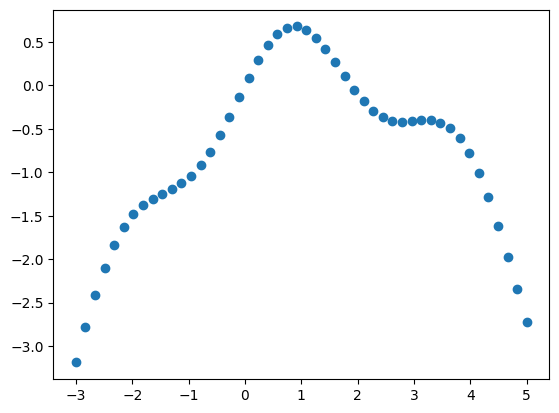

In [4]:
xleft = -3
xright = 5
n = 48
x = np.linspace(xleft,xright,n) # равномерно расплогаем на отрезке n точек
yf = np.zeros ((n))
y = np.zeros ((n))

# yf = np.sin(np.pi*x) #  1 вариант функции

for i in range(0,n): #  2 вариант функции
    if (x[i]<0) :
        yf[i] = 0.5*x[i] + 0.25*np.sin(2*x[i])
    elif (x[i]<np.pi):
        yf[i] = 0.5*x[i] + 0.5*np.sin(2*x[i])
    else:
        yf[i] = 0.5*x[i] + 0.75*np.sin(2*x[i])

yf = 0.5*x -0.2*(x**2)+0.4*np.sin(2*x) # 3 вариант функции
plt.plot (x,yf, 'o')

### Зашумление данных

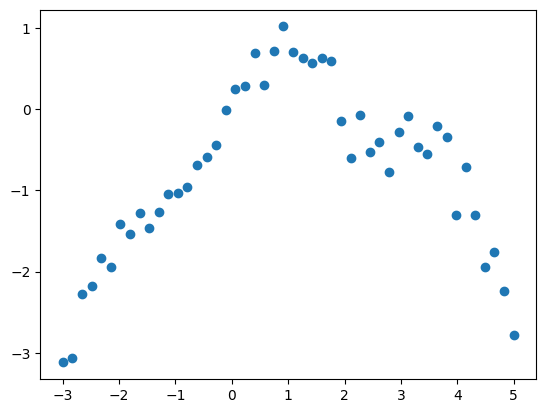

In [5]:
Delta = 0.25 * np.random.randn(len(x))
y = yf + Delta
plt.plot (x, y, 'o')

### Построение аппроксимационного полинома 

Коэффициенты [ 1.48739212e-02  1.25970320e+00 -2.10444819e-02 -3.52946114e-01
 -1.39266590e-01  3.49759322e-02  3.81240732e-02 -1.09387334e-03
 -4.61971066e-03  2.83393255e-04  2.12324570e-04 -2.69744370e-05
 -6.70882788e-07  1.32335052e-07]
Число обусловленности 8.087104743135838e+18 2924665187.5408096
Максимальное и минимальное собственные значения G 2.583174565867846e+18 0.1557498424265139


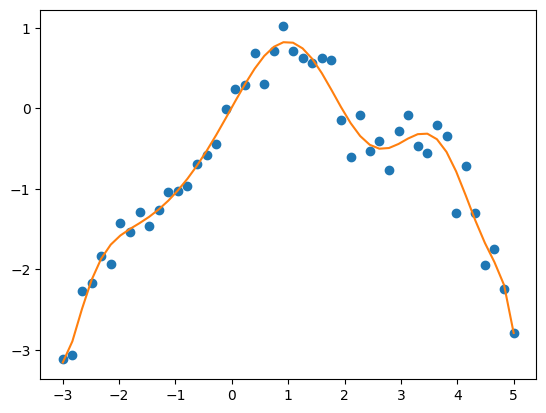

In [6]:
m = 13

PolynomCoefs = SqLeast (x, y, m)
print ('Коэффициенты', PolynomCoefs)

#print ('Gmatrix',G)
cond = np.linalg.cond (G)
condPhi = np.linalg.cond (Phi)
EigG = np.linalg.eigvals (G)
print ('Число обусловленности', cond, condPhi)
print ('Максимальное и минимальное собственные значения G', max (EigG), min (EigG))

PolynomValue = np.zeros(len(x))
for j in range (0, m+1):
    PolynomValue += PolynomCoefs[j]*x**j   

#ResLocal, ResLocalRel, ResGlobal, ResGlobalRel = AppError (x,y,PolynomCoefs)
#ResLocal, ResLocalRel, ResGlobal, ResGlobalRel, MSE, RSE, R2, R22 = AppError (x,y,PolynomCoefs)

plt.plot (x, y, 'o')
plt.plot (x, PolynomValue)

### Оценка погрешности аппроксимации

Погрешность аппроксимации
абсолютная, относительная, коэффициент детерминации
0.19387037473872182 0.18512721246283173 0.9657279152057415
1.0


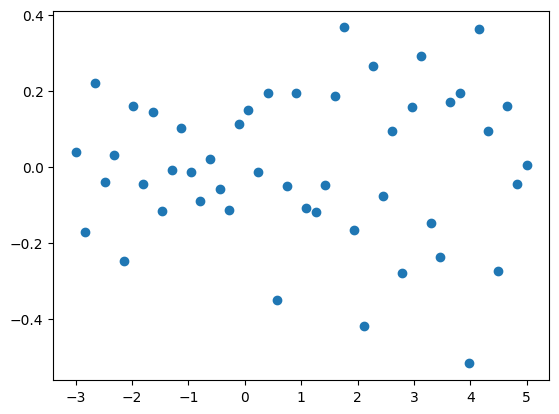

In [7]:
#ResLocal, ResLocalRel, ResGlobal, ResGlobalRel = AppError (x,y,PolynomCoefs)
#R2 = R2calc (x,y,PolynomCoefs)
ResLocal, SE, SErel, R2 = AppError (x,y,PolynomCoefs)
plt.plot (x, ResLocal, 'o')
print ('Погрешность аппроксимации')
print ('абсолютная, относительная, коэффициент детерминации')
print (SE, SErel, R2)
print (SErel**2+R2)

## Апроксимация с помощью машинного обучения

### Разделение данных на обучающий и тестовый наборы 


In [8]:
n = len(x)
ntest = int (n/4)
ntrain = n - ntest
xtrain = np.zeros (ntrain)
xtest = np.zeros (ntest)
ytrain = np.zeros (ntrain)
ytest = np.zeros (ntest)
#indtest = np.random.random_integers(0,n, ntest)
indtest = np.random.choice (len(x), ntest, replace = False)
print ("Индексы тестовых иксов:", indtest)

itest = -1
itrain = -1
for i in range (0,n):
    
    ktest = 0
    
    for k in range (0, ntest): 
        if (i==indtest[k]):
            itest += 1
            xtest [itest] = x[i]
            ytest [itest] = y[i]
            ktest = 1
            
    if (ktest !=1 ):
        itrain += 1
        xtrain [itrain] = x[i]
        ytrain [itrain] = y[i]
             
# print (xtest)
# print (xtrain)

Индексы тестовых иксов: [36  0 35 29  1 22 25 21 17 27 46 41]


### Решение методом наименьших квадратов

SEtrain, SEtest 0.14266060658767588 0.7042157704216633
R2train, R2test 0.9759369795174277 0.7302382700527795


/tmp/ipykernel_342770/4261429939.py:24: RuntimeWarning: invalid value encountered in scalar power
  RSE = (RSS/(len(x)-m))**0.5


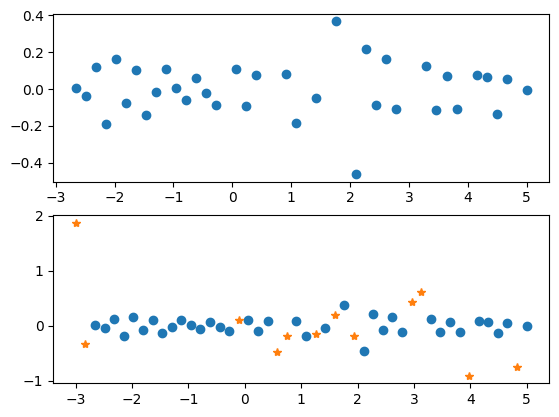

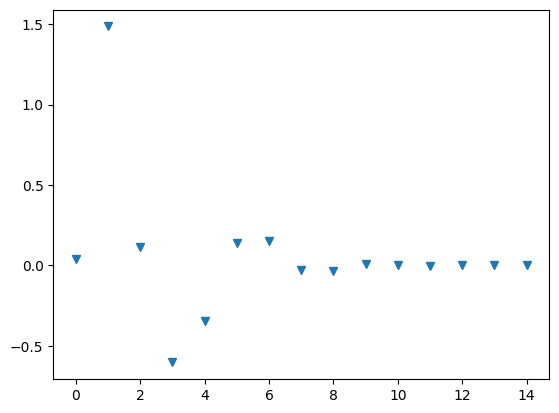

In [9]:
m = 14

PolynomCoefsTrain = SqLeast (xtrain, ytrain, m) # обучаем
    
ResLocalTrain, SETrain, SErelTrain, R2Train = AppError (xtrain,ytrain,PolynomCoefsTrain) # результаты на обучающей выборке
ResLocalTest, SETest, SErelTest, R2Test = AppError (xtest,ytest,PolynomCoefsTrain) # результаты на тестовой выборке   
    
print ('SEtrain, SEtest', SETrain, SETest)
print ('R2train, R2test', R2Train, R2Test)
#print (R2Train+SErelTrain**2, R2Test+SErelTest**2)
 
plt.subplot (2,1,1)
plt.plot (xtrain, ResLocalTrain, 'o') # Ошибки на обучающей выборке
plt.subplot (2,1,2)
plt.plot (xtrain, ResLocalTrain, 'o') # Ошибки на обучающей выборке
plt.plot (xtest, ResLocalTest, '*') # Ошибки на тестовой выборке
plt.figure ()
plt.plot (PolynomCoefsTrain, 'v') # Отображение коэффициентов полинома


### График получившейся апроксимации

m = 14
SEtrain, SEtest 0.14266060658767588 0.7042157704216633
R2train, R2test 0.9759369795174277 0.7302382700527795


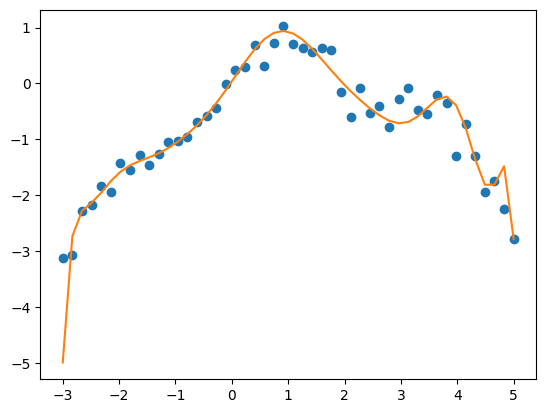

In [10]:
plt.plot (x, y, 'o')

PolynomValueTrain = np.zeros(len(x))
for j in range (0, m+1):
    PolynomValueTrain += PolynomCoefsTrain[j]*x**j

plt.plot (x, PolynomValueTrain)
print("m =", m)
print ('SEtrain, SEtest', SETrain, SETest)
print ('R2train, R2test', R2Train, R2Test)

### Решение методом наименьших квадратов (+кросс-валидация)

#### Разделение данных на k фолдов

In [11]:
def k_fold_split(X, y, k):
    
    # Перемешиваем индексы данных для случайного разбиения
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    # Определяем размер каждого фолда
    fold_size = len(X) // k
    
    # Делаем список для хранения фолдов
    X_folds = []
    y_folds = []
    
    # цикл по фолдам
    for i in range(k):
        # Получаем индексы текущего фолда
        start_idx = i * fold_size
        if i == k - 1:  # Последний фолд может быть больше из-за деления
            end_idx = len(X)
        else:
            end_idx = (i + 1) * fold_size
        
        fold_indices = indices[start_idx:end_idx]
        
        # Создаем фолды по индексам
        X_folds.append(X[fold_indices])
        y_folds.append(y[fold_indices])
    
    return X_folds, y_folds

In [12]:
k = 5

# Делим тестовую выборку на k фолдов
X_folds, y_folds = k_fold_split(xtrain, ytrain, k)

#### Реализация цикла для кросс-валидации:

In [13]:
# SqLeast(X, y, m) — обучение полиномиальной модели
# AppError(X, y, coefs) — расчет ошибки и метрик ->  SE (среднеквадратическая ошибка) и R^2(коэффициент детерминации)

def cross_validate(X_folds, y_folds, m):
    SE_train_folds = []
    SE_test_folds = []
    R2_train_folds = []
    R2_test_folds = []
    
    k = len(X_folds)  # Количество фолдов
    
    for i in range(k):
        # Разделяем на обучающую и тестовую выборку
        X_test = X_folds[i]
        y_test = y_folds[i]
        
        # Все остальные фолды используются для обучения
        X_train = np.concatenate([X_folds[j] for j in range(k) if j != i])
        y_train = np.concatenate([y_folds[j] for j in range(k) if j != i])
        
        # Обучение модели
        PolynomCoefsTrain = SqLeast(X_train, y_train, m)
        
        # Оценка на обучающей выборке
        ResLocalTrain, SETrain, SErelTrain, R2Train = AppError(X_train, y_train, PolynomCoefsTrain)
        
        # Оценка на тестовой выборке
        ResLocalTest, SETest, SErelTest, R2Test = AppError(X_test, y_test, PolynomCoefsTrain)
        
        # Сохранение метрик для текущего фолда
        SE_train_folds.append(SETrain)
        SE_test_folds.append(SETest)
        R2_train_folds.append(R2Train)
        R2_test_folds.append(R2Test)
    
    # Усреднение метрик по всем фолдам
    SETrain_mean = np.mean(SE_train_folds)
    SETest_mean = np.mean(SE_test_folds)
    R2Train_mean = np.mean(R2_train_folds)
    R2Test_mean = np.mean(R2_test_folds)
    
    return SETrain_mean, SETest_mean, R2Train_mean, R2Test_mean

In [14]:
m = 11
print("m =", m)
# Кросс-валидация
SETrain_mean, SETest_mean, R2Train_mean, R2Test_mean = cross_validate(X_folds, y_folds, m)

# Вывод результатов
print(f'Средняя SETrain: {SETrain_mean}')
print(f'Средняя SETest: {SETest_mean}')
print(f'Средний R2Train: {R2Train_mean}')
print(f'Средний R2Test: {R2Test_mean}')


m = 10
print("m =", m)
# Кросс-валидация
SETrain_mean, SETest_mean, R2Train_mean, R2Test_mean = cross_validate(X_folds, y_folds, m)

# Вывод результатов
print(f'Средняя SETrain: {SETrain_mean}')
print(f'Средняя SETest: {SETest_mean}')
print(f'Средний R2Train: {R2Train_mean}')
print(f'Средний R2Test: {R2Test_mean}')


m = 9
print("m =", m)
# Кросс-валидация
SETrain_mean, SETest_mean, R2Train_mean, R2Test_mean = cross_validate(X_folds, y_folds, m)

# Вывод результатов
print(f'Средняя SETrain: {SETrain_mean}')
print(f'Средняя SETest: {SETest_mean}')
print(f'Средний R2Train: {R2Train_mean}')
print(f'Средний R2Test: {R2Test_mean}')


m = 8
print("m =", m)
# Кросс-валидация
SETrain_mean, SETest_mean, R2Train_mean, R2Test_mean = cross_validate(X_folds, y_folds, m)

# Вывод результатов
print(f'Средняя SETrain: {SETrain_mean}')
print(f'Средняя SETest: {SETest_mean}')
print(f'Средний R2Train: {R2Train_mean}')
print(f'Средний R2Test: {R2Test_mean}')


m = 7
print("m =", m)
# Кросс-валидация
SETrain_mean, SETest_mean, R2Train_mean, R2Test_mean = cross_validate(X_folds, y_folds, m)

# Вывод результатов
print(f'Средняя SETrain: {SETrain_mean}')
print(f'Средняя SETest: {SETest_mean}')
print(f'Средний R2Train: {R2Train_mean}')
print(f'Средний R2Test: {R2Test_mean}')


m = 14
print("m =", m)
# Кросс-валидация
SETrain_mean, SETest_mean, R2Train_mean, R2Test_mean = cross_validate(X_folds, y_folds, m)

# Вывод результатов
print(f'Средняя SETrain: {SETrain_mean}')
print(f'Средняя SETest: {SETest_mean}')
print(f'Средний R2Train: {R2Train_mean}')
print(f'Средний R2Test: {R2Test_mean}')

m = 11
Средняя SETrain: 0.1447356236928937
Средняя SETest: 0.782514926168758
Средний R2Train: 0.9743915065535649
Средний R2Test: -0.12271077777316748
m = 10
Средняя SETrain: 0.14899414124021132
Средняя SETest: 0.5856598286897676
Средний R2Train: 0.972895731582007
Средний R2Test: 0.416036914339777
m = 9
Средняя SETrain: 0.151198484938826
Средняя SETest: 0.4987842949318552
Средний R2Train: 0.9721063056940975
Средний R2Test: 0.6115694157027552
m = 8
Средняя SETrain: 0.1542715894250048
Средняя SETest: 0.3513120713901537
Средний R2Train: 0.9708191137844191
Средний R2Test: 0.8189952037098296
m = 7
Средняя SETrain: 0.2152971282544745
Средняя SETest: 0.39737563645837304
Средний R2Train: 0.9431840349514008
Средний R2Test: 0.7819024590878663
m = 14
Средняя SETrain: 0.1242108137086956
Средняя SETest: 1.4804083678805922
Средний R2Train: 0.9809316513437206
Средний R2Test: -3.222915408008599


/tmp/ipykernel_342770/4261429939.py:24: RuntimeWarning: invalid value encountered in scalar power
  RSE = (RSS/(len(x)-m))**0.5
/tmp/ipykernel_342770/4261429939.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  RSE = (RSS/(len(x)-m))**0.5


Можем предположить, что лучше взять 8 степень полинома

In [15]:
m = 8

PolynomCoefsTrain = SqLeast (xtrain, ytrain, m) # обучаем
    
ResLocalTrain, SETrain, SErelTrain, R2Train = AppError (xtrain,ytrain,PolynomCoefsTrain) # результаты на обучающей выборке
ResLocalTest, SETest, SErelTest, R2Test = AppError (xtest,ytest,PolynomCoefsTrain) # результаты на тестовой выборке   
    
print ('SEtrain, SEtest', SETrain, SETest)
print ('R2train, R2test', R2Train, R2Test)

SEtrain, SEtest 0.1657958292124724 0.5875928539169851
R2train, R2test 0.9674995622552022 0.8121886407835838


### График получившейся апроксимации

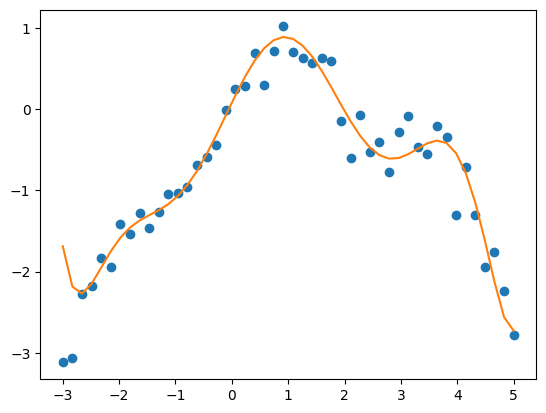

In [16]:
plt.plot (x, y, 'o')

PolynomValueTrain = np.zeros(len(x))
for j in range (0, m+1):
    PolynomValueTrain += PolynomCoefsTrain[j]*x**j

plt.plot (x, PolynomValueTrain)

### Использование scikit-learn

0.9262125315193908
0.4014424000660316


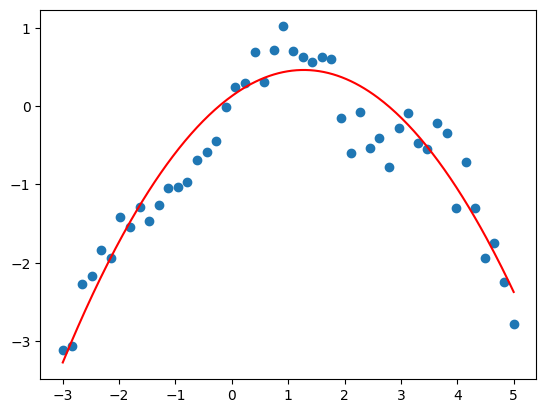

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
X2 = np.zeros ((len(x),1))
X2[:,0]=x

X_train, X_test, y_train, y_test =  train_test_split(X2,y, random_state=0)

degree=2

polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
pl=polyreg.fit(X_train,y_train)

pl.score(X_train,y_train)
pl.score(X_test,y_test)
X_seq = np.linspace(X2.min(),X2.max(),300).reshape(-1,1)
plt.figure()
plt.scatter(X2,y)
plt.plot(X_seq,polyreg.predict(X_seq),color="red")

print (pl.score(X_train,y_train))
print (pl.score(X_test,y_test))

### Использование scikit-learn (+кросс-валидация)

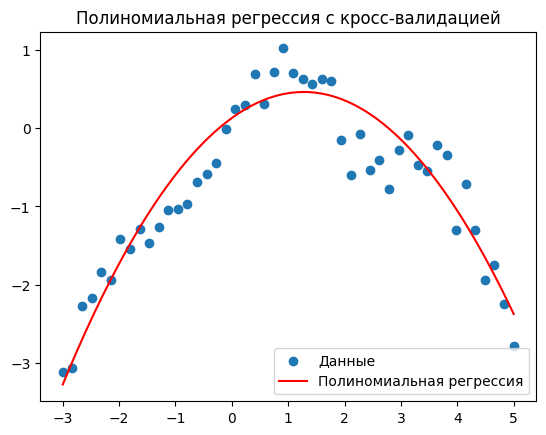

Кросс-валидационные оценки: [0.91542889 0.74983988 0.96997031 0.85687411 0.92606913]
Среднее значение кросс-валидации: 0.883636464131478
Оценка на обучающей выборке: 0.9262125315193908
Оценка на тестовой выборке: 0.4014424000660316


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt

# Формирование данных (предполагается, что x и y уже определены)
X2 = np.zeros((len(x), 1))
X2[:, 0] = x

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X2, y, random_state=0)

# Степень полинома
degree = 2

# Создание конвейера полиномиальной регрессии
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Кросс-валидация
cv_scores = cross_val_score(polyreg, X_train, y_train, cv=5)  # 5-фолдовая кросс-валидация

# Обучение модели
polyreg.fit(X_train, y_train)

# Оценка производительности модели
train_score = polyreg.score(X_train, y_train)
test_score = polyreg.score(X_test, y_test)

# Подготовка для графика
X_seq = np.linspace(X2.min(), X2.max(), 300).reshape(-1, 1)

# Визуализация
plt.figure()
plt.scatter(X2, y, label='Данные')
plt.plot(X_seq, polyreg.predict(X_seq), color="red", label='Полиномиальная регрессия')
plt.title("Полиномиальная регрессия с кросс-валидацией")
plt.legend()
plt.show()

# Вывод результатов
print("Кросс-валидационные оценки:", cv_scores)
print("Среднее значение кросс-валидации:", cv_scores.mean())
print("Оценка на обучающей выборке:", train_score)
print("Оценка на тестовой выборке:", test_score)


## Дополнительная часть (не поняла зачем)

(15480, 8)
[ 4.47600069e-01  9.56752596e-03 -1.24755956e-01  7.94471254e-01
 -1.43902596e-06 -3.44307993e-03 -4.18555257e-01 -4.33405135e-01]
0.609873031052925
0.5910509795491357


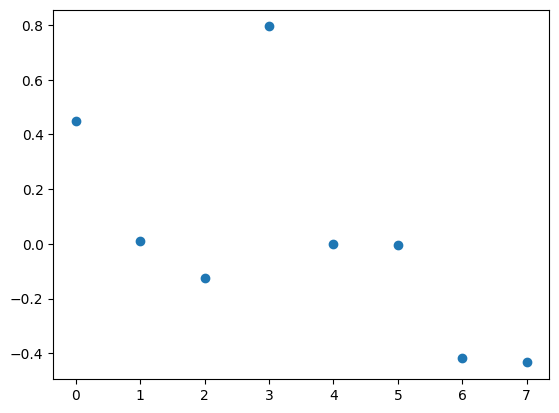

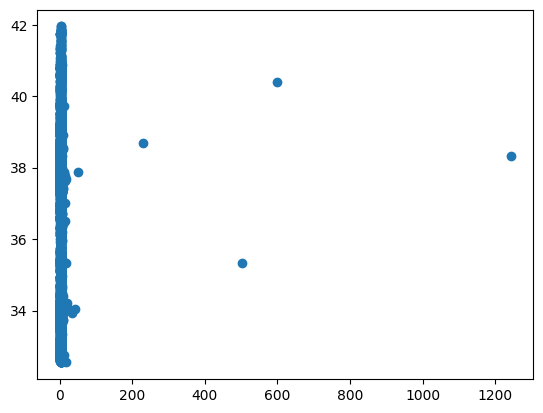

In [19]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()
XB = california.data
yB = california.target
X_train, X_test, y_train, y_test =  train_test_split(XB,yB, random_state=42)
print ("{}".format(X_train.shape))
lr=LinearRegression().fit(X_train, y_train)
print ("{}".format(lr.coef_))
lr.score(X_train,y_train)
lr.score(X_test,y_test)
print (lr.score(X_train,y_train))
print (lr.score(X_test,y_test))
plt.plot(lr.coef_, 'o')
plt.figure()
plt.scatter(X_train[:,5],X_train[:,6])

### Проблема обусловленности

In [20]:
n = 6
# Формирование матрицы Гильберта
MM = np.zeros ((n,n))
for i in range (0,n):
    for j in range (0,n):
        MM[i,j]=1/(i+j+1) #*10.
print (MM)
# Нахождение собственных значений матрицы
Evv = np.linalg.eigvals (MM)
print ('Eigen values', Evv)
# Формирование правой части
b = np.linspace (1,5,n)/n
print ('b',b)
# Нахождение решения системы уравнений
xx = np.linalg.solve(MM, b)
print ('solution',xx)
# Вычиление невязки
res = MM @ xx - b
print ('Residual', res)

MMinv = np.linalg.inv(MM)
normb = np.linalg.norm (b)
normM = np.linalg.norm (MM)
normMi = np.linalg.norm (MMinv)
normx = np.linalg.norm (xx)

#число обусловленности
cond = np.linalg.cond (MM)
print ('cond', cond, normM * normMi, max(Evv)/min(Evv))

#возмущение правой части
Del = (np.random.random(n)- 0.5) * 0.01
normDel = np.linalg.norm (Del)
b2 = b + Del
# Решение возмущенной системы
xx2 = np.linalg.solve(MM, b2)
print ('b', b2, )
print ('solution', xx2)
dx = xx-xx2
normdx = np.linalg.norm (dx)
res = MM @ xx2 - b2
print ('residual', res)

[[1.         0.5        0.33333333 0.25       0.2        0.16666667]
 [0.5        0.33333333 0.25       0.2        0.16666667 0.14285714]
 [0.33333333 0.25       0.2        0.16666667 0.14285714 0.125     ]
 [0.25       0.2        0.16666667 0.14285714 0.125      0.11111111]
 [0.2        0.16666667 0.14285714 0.125      0.11111111 0.1       ]
 [0.16666667 0.14285714 0.125      0.11111111 0.1        0.09090909]]
Eigen values [1.61889986e+00 2.42360871e-01 1.63215213e-02 6.15748354e-04
 1.25707571e-05 1.08279948e-07]
b [0.16666667 0.3        0.43333333 0.56666667 0.7        0.83333333]
solution [   -29.00000001    987.00000016  -7672.00000112  22344.00000293
 -27090.00000324  11550.00000128]
Residual [ 3.03174152e-13 -7.27584659e-13 -3.94129174e-13  3.94018151e-13
 -4.09339229e-13 -5.30575583e-13]
cond 14951058.642254734 15118987.12835571 14951058.641395982
b [0.16686733 0.29974446 0.43701854 0.56362516 0.70167819 0.83541702]
solution [   13.45547418  -182.50679092    48.08716297  2624.6

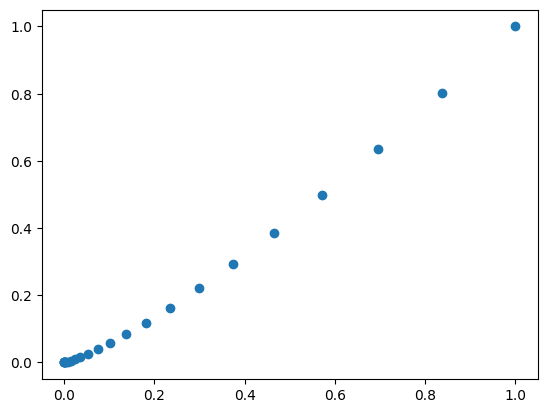

In [21]:
xleft = 0
xright = 1
n = 24
x1 = np.linspace(xleft,xright,n)
y1 = np.zeros ((n))
y2 = np.zeros ((n))
y1 = x1**4 
y2 = x1**5
plt.plot (y1,y2, 'o')

## Пример 3

Коэффициенты точные [-1.   1.   2.   1.  -1.  -0.5]
Коэффициенты МНК [-1.17575069  2.26910862 -0.98611646  4.12473779 -2.49060352 -0.23792188]
12373162.972734565
Коэффициенты МНК с регуляризацией [-1.13528344  1.6055853   1.4710359   0.73322215 -0.54539572 -0.63062742]
369807.63413100096
s [6.17413874e+01 6.54357569e+00 2.56943786e+00 7.10994096e-01
 1.39866108e-01 1.75523802e-02]


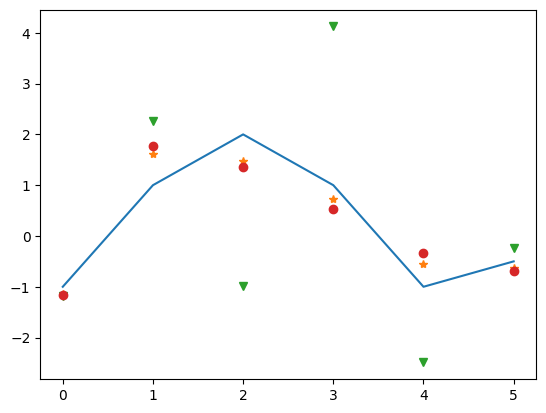

In [22]:
xleft = 0.0
xright = 2.0
n = 24
x_array = np.linspace(xleft,xright,n)
yf_array = np.zeros ((n))
y_array = np.zeros ((n))

coefs = np.array ([-1, 1, 2, 1,-1,-0.5])
m = len(coefs)- 1

print ('Коэффициенты точные', coefs)

for i in range (0, m+1):
    yf_array += coefs[i]*x_array**i
#plt.plot (x,yf, 'o')

Delta = 0.1 * np.random.randn(len(x_array))
y_array = yf_array + Delta
#plt.plot (x, y, '*')

PolynomCoefs = SqLeast (x_array, y_array, m)
print ('Коэффициенты МНК', PolynomCoefs)

#print ('Gmatrix',G)
cond = np.linalg.cond (G)
print (cond)

PolynomValue = np.zeros(len(x_array))
for i in range (0, m+1):
    PolynomValue += PolynomCoefs[i]*x_array**i
        
#plt.plot (x, y, 'o')
#plt.plot (x, PolynomValue)
#plt.subplot (x, ErrorLocal)

CoefsReg = SqLeastReg (x_array, y_array, m, 0.01)
print ('Коэффициенты МНК с регуляризацией', CoefsReg)
cond = np.linalg.cond (G)
print (cond)

PolynomValue = np.zeros(len(x_array))
for i in range (0, m+1):
    PolynomValue += CoefsReg[i]*x_array**i
#plt.plot (x, PolynomValue)

PhiInv = np.linalg.pinv(Phi, rcond = 1e-2)
CoefsSVD = PhiInv @ y_array
#print ('коэффициенты МНК SVD', CoefsSVD )

U, s, Vh = np.linalg.svd(Phi)
print ('s', s)
#smat = np.diag(s)

#plt.subplot (2,1,1)
plt.plot (coefs)
plt.plot (CoefsReg, '*')
plt.plot (PolynomCoefs, 'v')
plt.plot (CoefsSVD, 'o')
#plt.plot (coef2, '-')
#plt.subplot (2,1,2)
#plt.plot (coefs)
#plt.plot (coef2)